# AOTY 2023
It's that time of year again where album of the year is done and I throw around a series of graphs for no real reason. Let's get started.

### Setting up the environment
First we need to set up our environment. There's only a few modules we need.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plot_styles
import seaborn as sns

In [2]:
plt.style.use('spotify')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Geomanist'
plt.rcParams['font.weight'] = 'regular'

In [3]:
graph_dir = Path('Graphs')
graph_dir.mkdir(exist_ok=True)

### Importing the data
First, we need to import the data. This __won't be uploaded here__, so you'll have to ask [Pip](https://www.twitter.com/philipcopley) nicely for a copy if you want to do anything with it. We're also going to process it... quite a bit, to get it into a nice format to play with:
- Drop the total column so we can calculate our own
- Drop any empty rows or columns that we've accidentally grabbed from Excel
- Make sure we don't have any duplicate Artist rows
- Count the number of lists each album has appeared in

In [4]:
df = pd.read_excel('AOTY.xlsx', sheet_name='Albums')\
       .drop('TOTAL', axis=1)\
       .rename(columns={'Unnamed: 0': 'Artist'})\
       .dropna(axis=0, subset=['Artist'])\
       .dropna(axis=1, how='all')\
       .dropna(axis=0, how='all')\
       .fillna(0)\
       .groupby('Artist').sum()

# Make sure we use title case for names
df.columns = [c.title() for c in df.columns]

df = df[sorted(df.columns)]
df['Total'] = df.sum(axis=1, numeric_only=True)
df['Inclusions'] = df[[c for c in df.columns if c != 'Total']].astype(bool).sum(axis=1)

C:\Anaconda3\envs\data_analysis\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


### Getting the Top 20
We're going to graph the top 20 a lot. So let's pull them out to work with, and sort at the same time.

In [5]:
top_scores = sorted(df['Total'].tolist())[-20:]

top_20 = df[df['Total'].isin(top_scores)].sort_values(by='Total', ascending=False)

### Total Scores
The most simple graph we can do is a bar chart of the top 20.

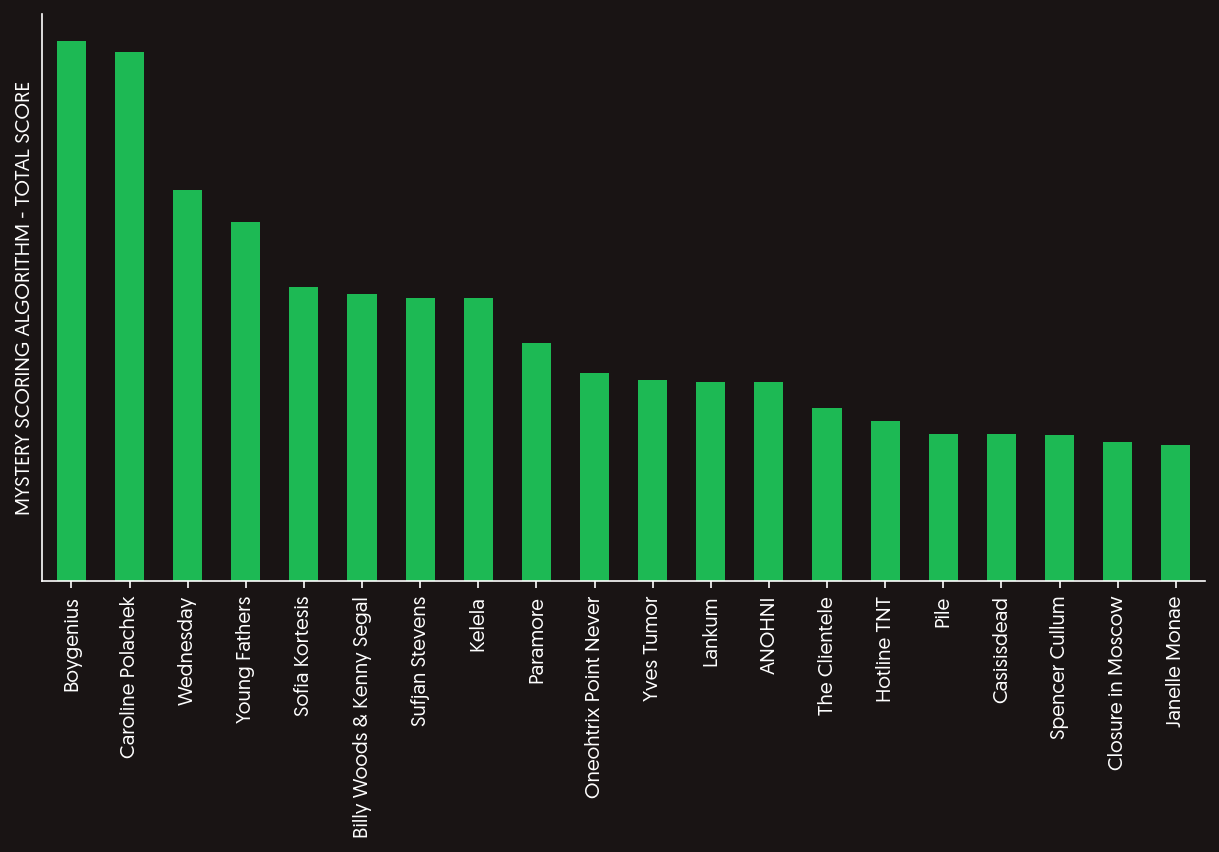

In [6]:
ax = top_20.plot.bar(y='Total', legend=False, figsize=(10, 5))
ax.set(yticks=[], ylabel='MYSTERY SCORING ALGORITHM - TOTAL SCORE', xlabel='')
ax.grid(visible=False)
plt.savefig(graph_dir / '01 Total Score.png', bbox_inches='tight')

Crikey this is a tight year. Not much at all between the top two, and then a little drop and some more really tight bundles.

### Score Distributions
Now things start getting a little more complicated - how are scores for the top 20 distributed? Are they coming up because they're liked by lots of people, or loved by a handful of committed fans? 

First what we'll do is get just the individual scores for each album on the lists they appear on. Then, we can show the data nicely with a box plot.

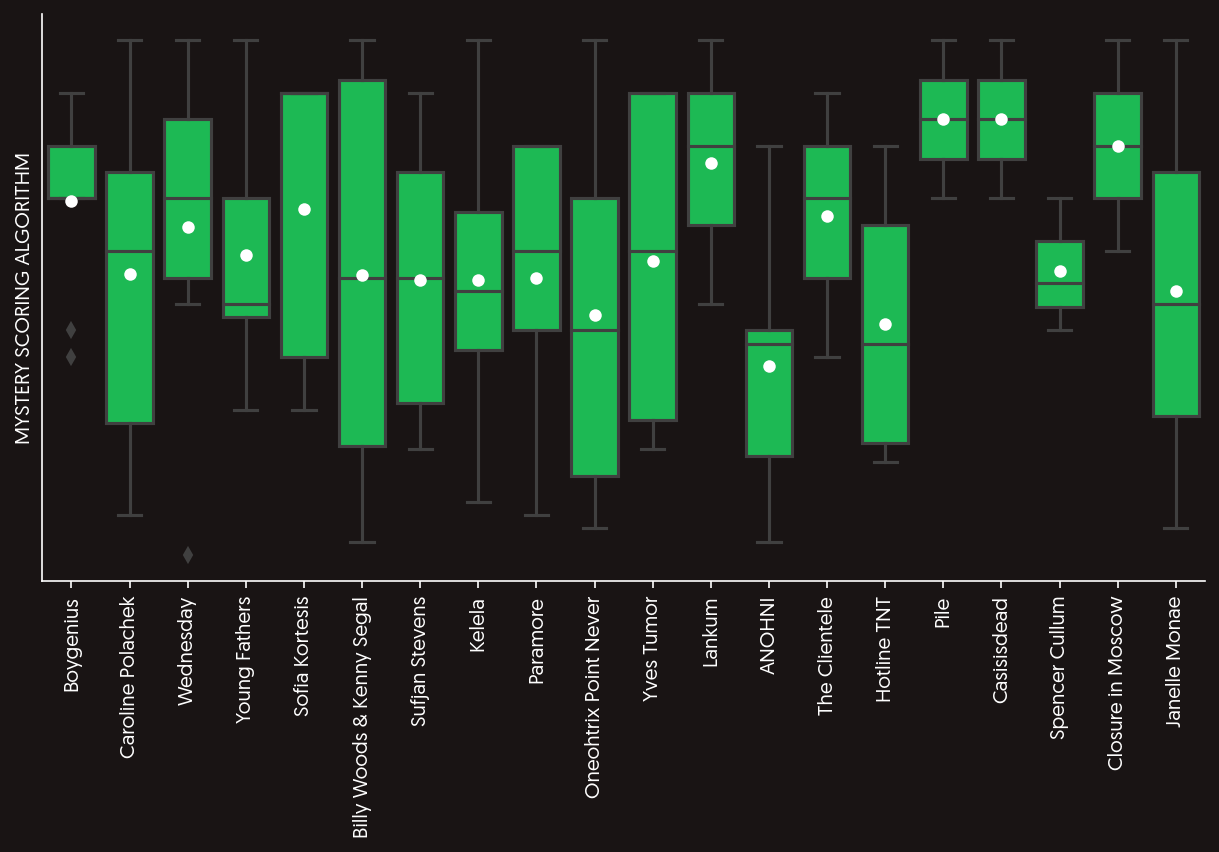

In [7]:
pvt = top_20.drop(['Total', 'Inclusions'], axis=1).stack().reset_index()
pvt.columns = ['Artist', 'Reviewer', 'Score']
pvt = pvt[(pvt['Score'] > 0)]

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(
    x=pvt['Artist'], y=pvt['Score'], showmeans=True, color='C0', saturation=1,
    meanprops=dict(marker='o', markerfacecolor='white', markeredgewidth=0)
)
ax.set(yticks=[], ylabel='MYSTERY SCORING ALGORITHM', xlabel='')
plt.xticks(rotation=90)
plt.savefig(graph_dir / '02 Score Distributions.png', bbox_inches='tight')

Bit of a mixed bag here - Caroline Polachek really getting a variety of scores, and Closure in Moscow only ranking highly.

### Number of List Inclusions
We've already got all the information we need to make this graph from our `top_20` frame

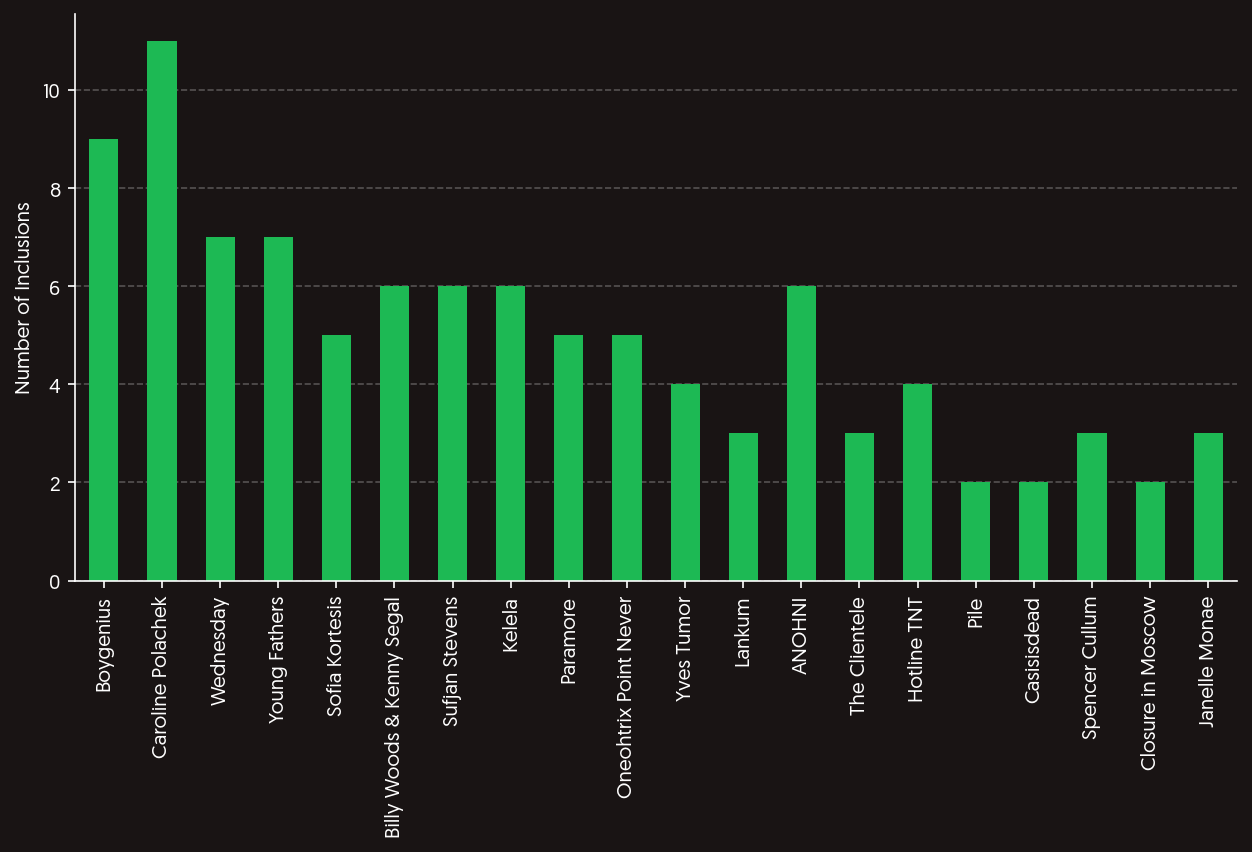

In [8]:
ax = top_20.plot.bar(y='Inclusions', legend=False, figsize=(10, 5), zorder=2)
ax.set(xlabel='', ylabel='Number of Inclusions')
ax.grid(axis='y', zorder=1, alpha=.4, ls='--')

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.savefig(graph_dir / '03 Inclusions.png', bbox_inches='tight')

This tracks with what we say in the box plot. Caroline Polachek showing up on a lot of lists, and some of the lower-ranked albums placing from only a few appearances.

### Similar Tastes
We might also want to consider who of the AOTY participants had the most similar lists. To do this, we make a correlation matrix showing the correlation between each person. This will be symmetrical, so we will just take the upper half of it and then stack it into a column. Then we can pick out the top ten people with similar tastes.

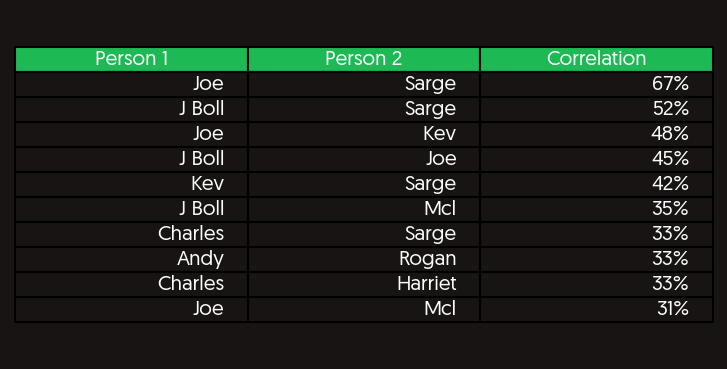

In [9]:
person_corr = df.drop(['Total', 'Inclusions'], axis=1).corr()

# Name the index and columns - it'll help later
person_corr.index.name = 'Person 1'
person_corr.columns.name = 'Person 2'

person_results = person_corr.mask(np.tril(np.ones(person_corr.shape)).astype(bool)).stack()

person_results.name = 'Correlation'
person_results = person_results.reset_index()\
                               .sort_values(by='Correlation', ascending=False)\
                               .reset_index(drop=True)\
                               .head(10)

# Convert to text for easier use
person_results['Correlation'] = person_results['Correlation'].apply('{:.0%}'.format)


# Plot the table!
fig, ax = plt.subplots(figsize=(6, 3))

ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame

ax.table(
    cellText=person_results.values, colLabels=person_results.columns, loc='center', 
    cellColours=np.full(person_results.values.shape, '#ffffff00'),
    colColours=['C0' for _ in person_results.columns]
)

plt.savefig(graph_dir / '04 Person correlation.png', bbox_inches='tight')

### Similar Albums
Similarly, we can consider which albums have tended to appear in lists together. The slight issue here is that there will be some albums that have only appeared on one list, meaning they'll necessarily have a correlation of 1. To avoid this, we'll first filter to select only albums that have appeared on more than 3 lists.

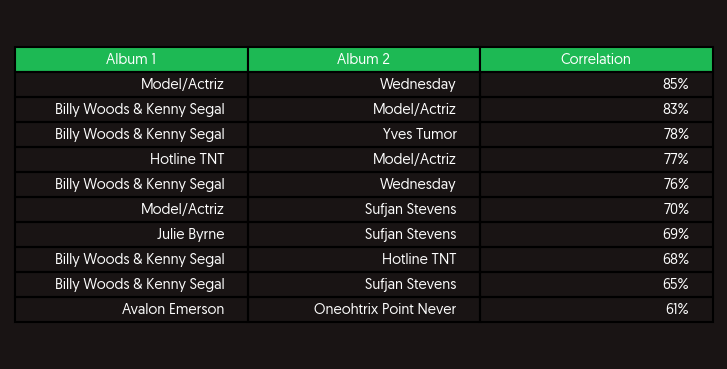

In [10]:
album_corr = df[df['Inclusions'] > 3].drop(['Total', 'Inclusions'], axis=1).transpose().corr()

# Name the index and columns - it'll help later
album_corr.index.name = 'Album 1'
album_corr.columns.name = 'Album 2'

album_results = album_corr.mask(np.tril(np.ones(album_corr.shape)).astype(bool)).stack()

album_results.name = 'Correlation'
album_results = album_results.reset_index()\
                             .sort_values(by='Correlation', ascending=False)\
                             .reset_index(drop=True)\
                             .head(10)

# Convert to text for easier use
album_results['Correlation'] = album_results['Correlation'].apply('{:.0%}'.format)


# Plot the table!
fig, ax = plt.subplots(figsize=(6, 3))

ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame

ax.table(
    cellText=album_results.values, colLabels=album_results.columns, loc='center', 
    cellColours=np.full(album_results.values.shape, '#ffffff00'),
    colColours=['C0' for _ in album_results.columns]
)

plt.savefig(graph_dir / '05 Album correlation.png', bbox_inches='tight')